In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
from gpn.data import Genome

enformer = pd.read_parquet("../../results/enformer/merged.parquet")
genome = Genome("../../results/genome.fa.gz")
enformer["ref_nuc"] = enformer.progress_apply(lambda v: genome.get_nuc(v.chrom, v.pos).upper(), axis=1)
mask = enformer['ref'] != enformer['ref_nuc']
enformer.loc[mask, ['ref', 'alt']] = enformer.loc[mask, ['alt', 'ref']].values
enformer.to_parquet("../../results/enformer/merged.correct_ref_alt.parquet", index=False)
""";

In [4]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/ge"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [7]:
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
enformer

,chrom,pos,ref,alt,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,10642,G,A,-4.500000,-0.130371,-0.044769,G
1,1,11008,C,G,-3.861328,-0.087769,-0.032928,C
2,1,11012,C,G,-12.265625,-0.251465,-0.085571,C
3,1,11063,T,G,-6.304688,-0.156494,-0.029846,T
4,1,13110,G,A,-1.482422,-0.043243,-0.009705,G
...,...,...,...,...,...,...,...,...
25273048,22,50802392,C,T,-0.846680,-0.020538,-0.006084,C
25273049,22,50802857,T,G,-2.433594,-0.051331,-0.017822,T
25273050,22,50802958,C,G,-3.312500,-0.091431,-0.012917,C
25273051,22,50805735,A,G,-2.132812,-0.042755,-0.004509,A


In [5]:
models = [
    #"CADD.RawScore",
    #"phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

embedding_models = models[-1:] + [
    #"Enformer",
    #"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA
0,1,14677,G,A,0.992227,0.055024,True,0,-1.095703
1,1,54490,G,A,1.000000,0.159938,True,1,0.039062
2,1,63671,G,A,0.998592,0.156388,True,2,3.130859
3,1,63697,T,C,0.977568,0.195652,True,3,-6.382812
4,1,108826,G,C,1.000000,0.040023,True,4,-0.430176
...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,-0.135254
21572,X,155559972,A,T,0.008540,0.279240,False,10678,-5.105469
21573,X,155672303,G,A,0.962191,0.436727,True,10785,2.652344
21574,X,155768650,G,T,0.991784,0.455970,True,10786,7.382812


In [6]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_758,GPN-MSA_embedding_759,GPN-MSA_embedding_760,GPN-MSA_embedding_761,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767
0,1,14677,G,A,0.992227,0.055024,True,0,-1.095703,64.051559,...,89.824707,199.697739,77.445602,118.201614,76.433060,85.791702,116.796051,134.987656,98.808708,136.287567
1,1,54490,G,A,1.000000,0.159938,True,1,0.039062,74.008621,...,78.208862,195.499268,65.750397,116.176086,37.660343,61.358295,66.520416,222.334717,86.371178,123.405899
2,1,63671,G,A,0.998592,0.156388,True,2,3.130859,112.173599,...,60.808552,185.909119,56.564896,108.361557,48.274273,132.782913,117.334999,145.458588,78.315521,113.826729
3,1,63697,T,C,0.977568,0.195652,True,3,-6.382812,110.093887,...,54.705101,199.289352,62.102852,108.504623,44.504349,128.125107,97.484909,157.047974,88.589920,103.457596
4,1,108826,G,C,1.000000,0.040023,True,4,-0.430176,84.458160,...,58.063683,264.774780,43.647125,154.756607,48.543915,68.478287,37.299149,200.779083,90.404633,104.381027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,-0.135254,131.337006,...,167.191193,392.032898,51.982269,174.859619,64.837723,71.624405,102.168427,158.333191,97.730469,64.405762
21572,X,155559972,A,T,0.008540,0.279240,False,10678,-5.105469,97.270386,...,71.705826,106.798172,76.585175,100.152756,57.800224,109.551567,101.248871,242.203278,128.852570,98.423828
21573,X,155672303,G,A,0.962191,0.436727,True,10785,2.652344,206.697205,...,84.800644,603.541504,43.506001,241.218033,81.240509,96.263916,279.525177,298.535583,200.082535,77.113441
21574,X,155768650,G,T,0.991784,0.455970,True,10786,7.382812,69.112442,...,108.790283,68.111130,72.968346,104.211403,60.872177,148.564194,88.814606,97.447220,92.073914,120.256180


In [8]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

GPN-MSA


In [9]:
V = V.merge(enformer, on=cols, how="left")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,14677,G,A,0.992227,0.055024,True,0,-1.095703,64.051559,...,76.433060,85.791702,116.796051,134.987656,98.808708,136.287567,NaN,NaN,NaN,NaN
1,1,54490,G,A,1.000000,0.159938,True,1,-0.039062,74.008621,...,37.660343,61.358295,66.520416,222.334717,86.371178,123.405899,-1.388672,-0.039154,-0.008972,G
2,1,63671,G,A,0.998592,0.156388,True,2,-3.130859,112.173599,...,48.274273,132.782913,117.334999,145.458588,78.315521,113.826729,-5.425781,-0.119751,-0.015160,G
3,1,63697,T,C,0.977568,0.195652,True,3,-6.382812,110.093887,...,44.504349,128.125107,97.484909,157.047974,88.589920,103.457596,NaN,NaN,NaN,NaN
4,1,108826,G,C,1.000000,0.040023,True,4,-0.430176,84.458160,...,48.543915,68.478287,37.299149,200.779083,90.404633,104.381027,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21574,X,155203528,C,T,0.009518,0.279275,False,10692,-0.135254,131.337006,...,64.837723,71.624405,102.168427,158.333191,97.730469,64.405762,NaN,NaN,NaN,NaN
21575,X,155559972,A,T,0.008540,0.279240,False,10678,-5.105469,97.270386,...,57.800224,109.551567,101.248871,242.203278,128.852570,98.423828,NaN,NaN,NaN,NaN
21576,X,155672303,G,A,0.962191,0.436727,True,10785,-2.652344,206.697205,...,81.240509,96.263916,279.525177,298.535583,200.082535,77.113441,NaN,NaN,NaN,NaN
21577,X,155768650,G,T,0.991784,0.455970,True,10786,-7.382812,69.112442,...,60.872177,148.564194,88.814606,97.447220,92.073914,120.256180,NaN,NaN,NaN,NaN


In [12]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
1,1,54490,G,A,1.000000,0.159938,True,1,-0.039062,74.008621,...,37.660343,61.358295,66.520416,222.334717,86.371178,123.405899,-1.388672,-0.039154,-0.008972,G
2,1,63671,G,A,0.998592,0.156388,True,2,-3.130859,112.173599,...,48.274273,132.782913,117.334999,145.458588,78.315521,113.826729,-5.425781,-0.119751,-0.015160,G
5,1,286747,A,G,1.000000,0.151295,True,5,-0.951660,165.935150,...,73.595261,90.576538,304.911224,316.959534,176.152023,78.874352,-0.455322,-0.015839,-0.005482,A
7,1,912710,G,A,0.008546,0.222110,False,482,-0.188965,117.956886,...,43.985313,50.215504,47.813698,168.470795,44.346153,134.561707,-1.289062,-0.040924,-0.011650,G
8,1,917584,T,G,0.996919,0.199664,True,7,-4.042969,93.133698,...,47.943237,145.574554,114.146210,111.626595,92.902130,129.840927,-5.234375,-0.211548,-0.088135,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21050,22,50665387,T,A,0.006481,0.030702,False,10404,-1.267578,259.593750,...,50.282639,119.618774,89.921600,144.149048,101.947487,64.935715,-0.600098,-0.016815,-0.002787,T
21051,22,50665389,G,A,0.006481,0.030702,False,10418,-1.392578,260.005219,...,51.531116,127.022018,90.020309,140.705078,104.900696,67.650330,-0.986328,-0.025116,-0.004189,G
21052,22,50733265,G,A,0.971032,0.302632,True,10523,-0.100586,74.214806,...,51.559444,98.893044,90.362930,162.236786,75.311310,116.578255,-1.047852,-0.033752,-0.007000,G
21053,22,50783672,G,T,0.964513,0.080189,True,10524,-4.925781,62.349030,...,43.303207,82.037956,173.751007,85.423416,78.813248,106.367134,-68.375000,-1.552734,-0.204346,G


In [13]:
V = V[V.duplicated("match_group", keep=False)]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,GPN-MSA,GPN-MSA_embedding_0,...,GPN-MSA_embedding_762,GPN-MSA_embedding_763,GPN-MSA_embedding_764,GPN-MSA_embedding_765,GPN-MSA_embedding_766,GPN-MSA_embedding_767,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
1,1,54490,G,A,1.000000,0.159938,True,1,-0.039062,74.008621,...,37.660343,61.358295,66.520416,222.334717,86.371178,123.405899,-1.388672,-0.039154,-0.008972,G
2,1,63671,G,A,0.998592,0.156388,True,2,-3.130859,112.173599,...,48.274273,132.782913,117.334999,145.458588,78.315521,113.826729,-5.425781,-0.119751,-0.015160,G
5,1,286747,A,G,1.000000,0.151295,True,5,-0.951660,165.935150,...,73.595261,90.576538,304.911224,316.959534,176.152023,78.874352,-0.455322,-0.015839,-0.005482,A
7,1,912710,G,A,0.008546,0.222110,False,482,-0.188965,117.956886,...,43.985313,50.215504,47.813698,168.470795,44.346153,134.561707,-1.289062,-0.040924,-0.011650,G
8,1,917584,T,G,0.996919,0.199664,True,7,-4.042969,93.133698,...,47.943237,145.574554,114.146210,111.626595,92.902130,129.840927,-5.234375,-0.211548,-0.088135,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21050,22,50665387,T,A,0.006481,0.030702,False,10404,-1.267578,259.593750,...,50.282639,119.618774,89.921600,144.149048,101.947487,64.935715,-0.600098,-0.016815,-0.002787,T
21051,22,50665389,G,A,0.006481,0.030702,False,10418,-1.392578,260.005219,...,51.531116,127.022018,90.020309,140.705078,104.900696,67.650330,-0.986328,-0.025116,-0.004189,G
21052,22,50733265,G,A,0.971032,0.302632,True,10523,-0.100586,74.214806,...,51.559444,98.893044,90.362930,162.236786,75.311310,116.578255,-1.047852,-0.033752,-0.007000,G
21053,22,50783672,G,T,0.964513,0.080189,True,10524,-4.925781,62.349030,...,43.303207,82.037956,173.751007,85.423416,78.813248,106.367134,-68.375000,-1.552734,-0.204346,G


In [21]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []

for m in embedding_models:
    supervised_models.append((
        f"{m} - best inner product",
        lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    ))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))

#supervised_models.append((
#    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
#    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
#))

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
GPN-MSA - best inner product


100%|██████████| 768/768 [00:03<00:00, 233.08it/s]


GPN-MSA - LR(inner products)
['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
GPN-MSA - best inner product


100%|██████████| 768/768 [00:02<00:00, 256.45it/s]


GPN-MSA - LR(inner products)


## Testing

In [22]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"])
results

100%|██████████| 4/4 [00:00<00:00, 102.26it/s]


,Model,AUROC
0,GPN-MSA,0.538251
1,Enformer_l2,0.709088
2,GPN-MSA - best inner product,0.688298
3,GPN-MSA - LR(inner products),0.729152


In [23]:
#results.to_csv("results_eqtl.csv", index=False)

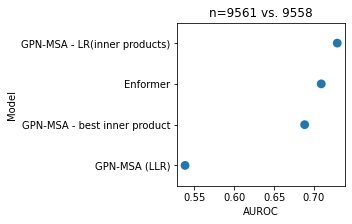

In [24]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.sort_values("AUROC", ascending=False).replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);